# Modelos de Regresion

Utilizando modelos de regresion, buscamos predecir la satisfaccion del cliente y los retrasos en entregas.

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV

# Abrir CSV
df = pd.read_csv('dataset/cleaned_orders.csv')
df['delivery_delayed'] =  df['delivery_delayed'].astype(int)
df['different_state'] = df['different_state'].astype(int)

# Eliminar algunas variables respuesta de otros modelos
df.drop(columns=['has_comment', 'has_title'], inplace=True)
df = df.dropna()

# Separar en test y train con 30/70 para predicciones de satisfaccion
dftrain, dftest = train_test_split(
    df,
    test_size=0.3,
    stratify=df['review_score'],
    random_state=42
)

# Separar en test y train con 30/70 para predicciones de delivery
dftrain_d, dftest_d = train_test_split(
    df,
    test_size=0.3,
    random_state=42
)

# Eliminar columnas que practicamente nos dan la respuesta
dftrain_d.drop(columns=['estimated_delivery_days', 'delivery_delayed', 'delivery_delta','review_score'], inplace=True)
dftest_d.drop(columns=['estimated_delivery_days', 'delivery_delayed', 'delivery_delta', 'review_score'], inplace=True)
dftrain_d.head(15)


,delivery_days,avg_product_price,total_order_price,item_count,order_freight_value,avg_product_weight,total_order_weight_g,avg_product_volume_cm3,total_order_volume_cm3,freight_to_price,...,customer_state_RR,customer_state_RS,customer_state_SC,customer_state_SE,customer_state_SP,customer_state_TO,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher
48973,16,44.90,44.90,1,15.11,900.0,900.0,13440.0,13440.0,0.336526,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17686,22,689.89,689.89,1,21.67,1500.0,1500.0,9075.0,9075.0,0.031411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
35797,6,37.99,37.99,1,11.85,1800.0,1800.0,9180.0,9180.0,0.311924,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
51599,6,135.00,135.00,1,14.70,500.0,500.0,1056.0,1056.0,0.108889,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
13447,10,89.90,89.90,1,17.20,1400.0,1400.0,8000.0,8000.0,0.191324,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
87458,7,6.90,20.70,3,14.52,100.0,300.0,704.0,2112.0,0.701449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45288,15,125.00,250.00,2,14.22,125.0,250.0,2304.0,4608.0,0.056880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12912,8,110.90,110.90,1,15.54,1500.0,1500.0,16928.0,16928.0,0.140126,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
84024,14,213.00,213.00,1,24.07,1000.0,1000.0,7500.0,7500.0,0.113005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
51872,9,949.99,949.99,1,21.97,4700.0,4700.0,36000.0,36000.0,0.023127,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Regresion Lineal

### Prediccion Satisfaccion Cliente

Primero, separamos los modelos entre X e Y con la variable objetivo

In [11]:
x_train = dftrain.drop(columns=['review_score'])
y_train = dftrain['review_score']

x_test = dftest.drop(columns=['review_score'])
y_test = dftest['review_score']

Empezando, vamos a realizar una regresion simple con todas las variables

R² Score: 0.178
MSE: 1.36


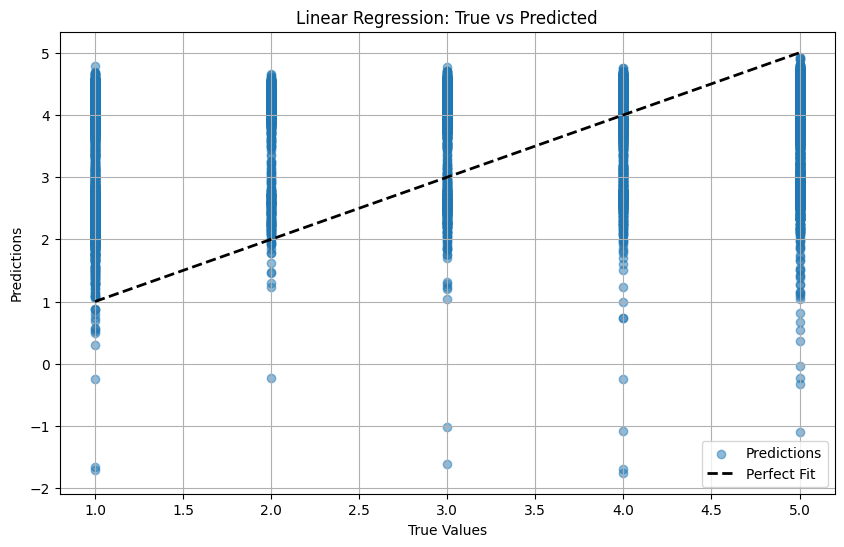

In [12]:
from sklearn.linear_model  import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

model = LinearRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Fit')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Linear Regression: True vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

Al tener algunas variables correlacionadas, debemos depurar las variables que incluimos dentro del modelo

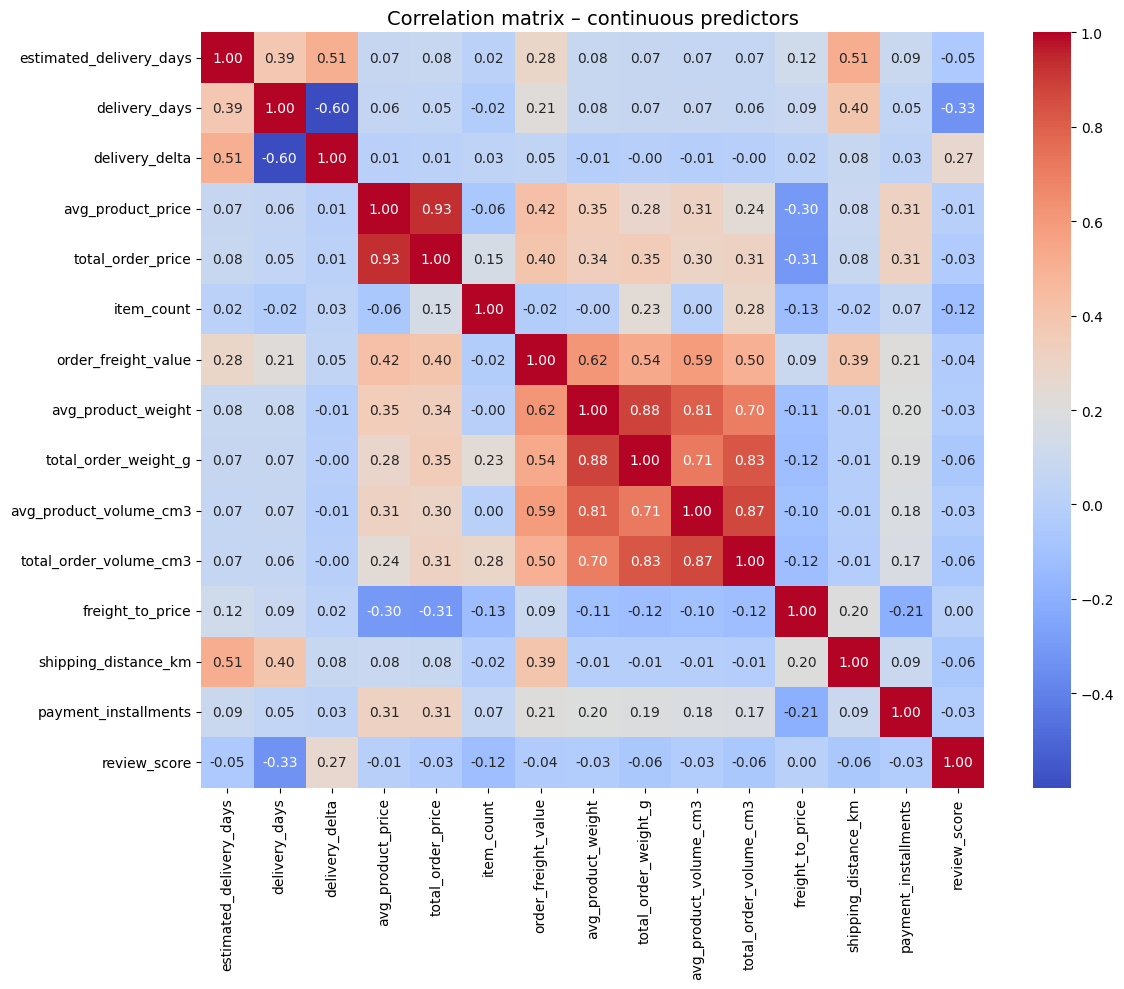

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns


cont_cols = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if (df[c].nunique() >= 3) and c != 'review_score'
]

df_cont = df[cont_cols + ['review_score']].dropna()

corr = df_cont.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f',
            xticklabels=corr.columns, yticklabels=corr.columns)
plt.title('Correlation matrix – continuous predictors', fontsize=14)
plt.tight_layout()
plt.show()

En la matriz de correlación anterior podemos observar que hay algunas variables que tienen correlación con review_score. Pero también podemos ver que hay regresores que tienen alta colinealidad entre ellos. Esto sugiere que el modelo debe ser depurado

In [14]:
X = df_cont.drop(columns=['review_score'])
y = df_cont['review_score']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)


def backward_elimination(X, y, sl=0.05):
    feats = X.columns.tolist()
    while True:
        model = sm.OLS(y, sm.add_constant(X[feats])).fit()
        pvals = model.pvalues.drop('const')
        worst_p = pvals.max()
        if worst_p > sl:
            feats.remove(pvals.idxmax())
        else:
            return model, feats

be_model, sel_feats = backward_elimination(X_train, y_train)

print("\n=== Resumen del modelo depurado (sin dummies) ===\n")
print(be_model.summary())
print(f"\nVariables seleccionadas: {sel_feats}")

usecols = sel_feats + ['review_score']
clear_df = pd.read_csv('dataset/cleaned_orders.csv', usecols=usecols)


=== Resumen del modelo depurado (sin dummies) ===

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     1339.
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:43:20   Log-Likelihood:            -1.2068e+05
No. Observations:               75622   AIC:                         2.414e+05
Df Residuals:                   75612   BIC:                         2.415e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

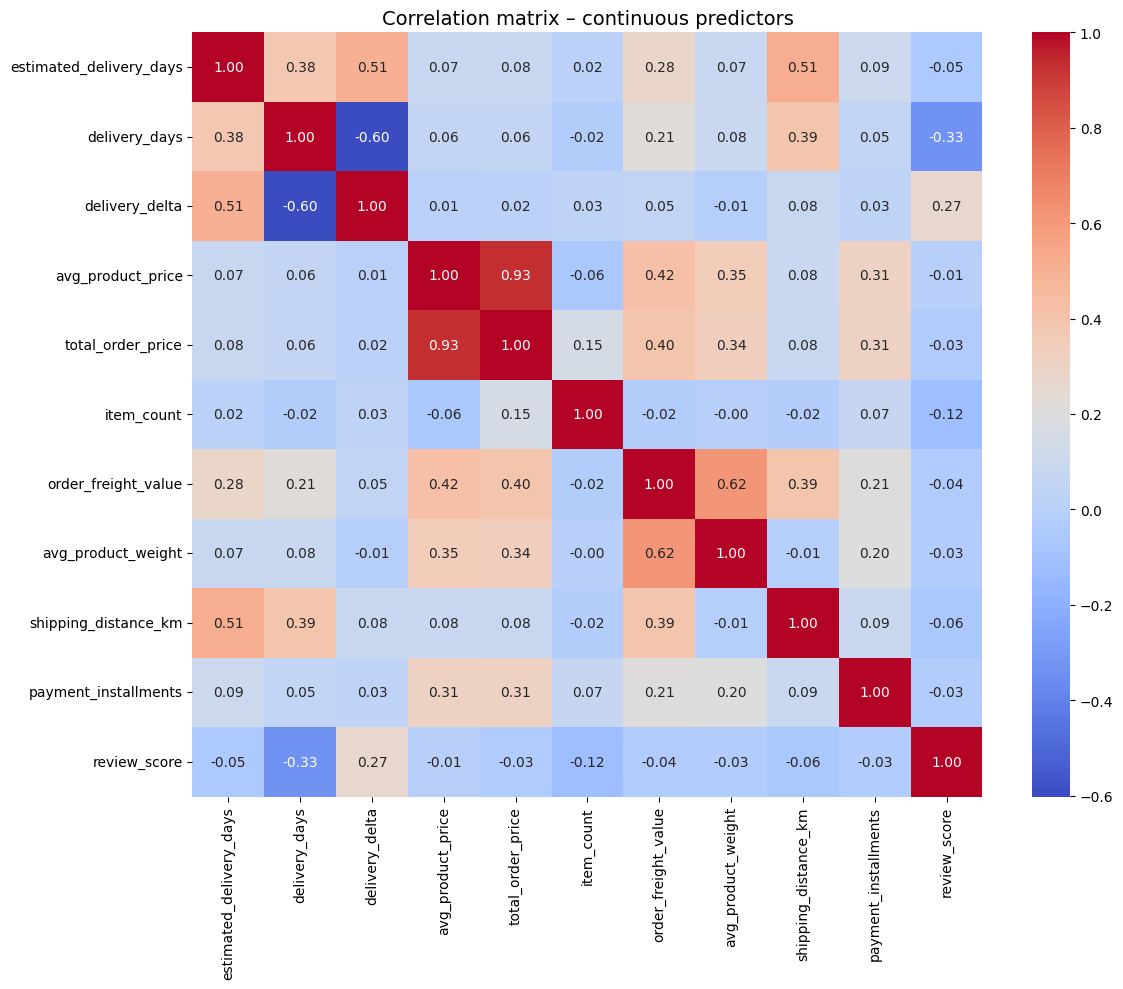

In [15]:
corr = clear_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f',
            xticklabels=corr.columns, yticklabels=corr.columns)
plt.title('Correlation matrix – continuous predictors', fontsize=14)
plt.tight_layout()
plt.show()

Luego de depurar el modelo, podemos observar que se conservaron las clumnas estimated_delvery_days, delivery_days, delivery_delta, avg_product_price, total_order_price, item_count, order_freight_value, avg_product_weight, shipping_distance_km y payment_installments


RMSE hold‑out: 1.1827
R² hold‑out: 0.1433


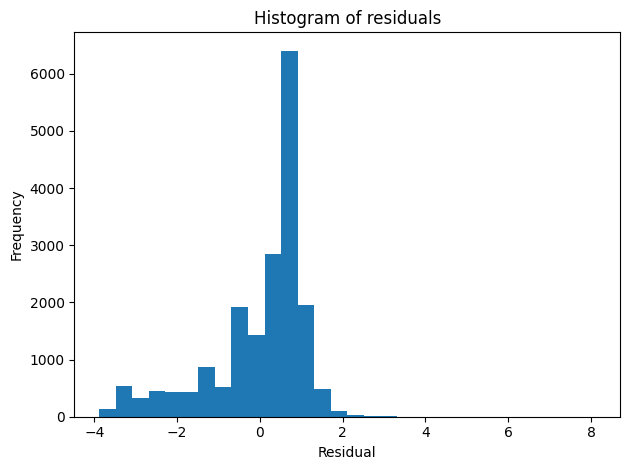

<Figure size 640x480 with 0 Axes>

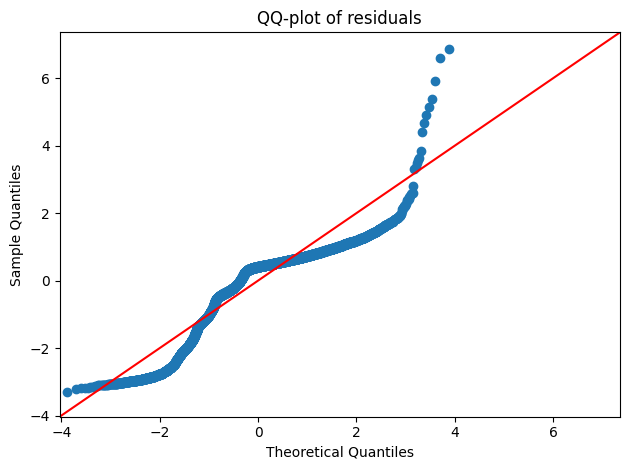

In [16]:
linreg = LinearRegression().fit(X_train[sel_feats], y_train)
y_pred = linreg.predict(X_test[sel_feats])
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'\nRMSE hold‑out: {rmse:.4f}')
print(f'R² hold‑out: {r2:.4f}')

residuals = y_test - y_pred

# Histograma de residuales
plt.figure()
plt.hist(residuals, bins=30)
plt.title('Histogram of residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# QQ‑plot
plt.figure()
qqplot(residuals, line='45', fit=True)
plt.title('QQ‑plot of residuals')
plt.tight_layout()
plt.show()

Los errores están centrados en 0 (modelo no sesgado en promedio) pero la distribución es asimétrica y con colas gruesas (kurtosis > 0).

Las colas de la distribución empírica son más pesadas que las de una normal; se confirma la falta de normalidad.

In [17]:
params = be_model.params
intercept = params['const']
betas = params.drop('const')


eq = f"ŷ = {intercept:.4f}"
for var, coef in betas.items():
    sign = "+" if coef >= 0 else "-"
    eq += f" {sign} {abs(coef):.4f}·{var}"

print("Ecuación del modelo lineal:")
print(eq)

Ecuación del modelo lineal:
ŷ = 4.8121 - 0.0107·estimated_delivery_days - 0.0315·delivery_days + 0.0208·delivery_delta + 0.0003·avg_product_price - 0.0003·total_order_price - 0.2860·item_count + 0.0010·order_freight_value - 0.0000·avg_product_weight + 0.0001·shipping_distance_km - 0.0058·payment_installments


En la parte de arriba podemos observar la ecuación del modelo ya depurado el cual nos maximiza el R² a un 0.137 y un adj-R² de 0.137 de igual forma

##

## Random Forest

Para implementar este modelo de regresion, primero vamos a elegir algunos valores iniciales para cada una de las regresiones que vamos a realizar. Luego, vamos a interpretar estos valores iniciales para intentar explicar ciertos comportamientos y predecir la influencia de valores mas optimos. Por ultimo, vamos a utilizar GridSearch para encontrar los valores optimos y analizar el rendimiento de este modelo optimizado

### Satisfaccion del Cliente

Importamos el regresor de random forest, creamos los splits X e Y tanto para prueba como para entrenamiento y entrenamos nuestro modelo inicial.

In [18]:
from sklearn.ensemble import RandomForestRegressor

# Separacion X / Y train
x_train = dftrain.drop(columns=['review_score'])
y_train = dftrain['review_score']

# Separacion X / Y test
x_test = dftest.drop(columns=['review_score'])
y_train = dftrain['review_score']

# Creacion de modelo
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 42, max_depth = 4)

# Entrenamiento de modelo
rf_regressor.fit(x_train, y_train)

# Predicciones con el modelo
y_pred = rf_regressor.predict(x_test)

# Estadisticas de rendimiento
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir estadisticas
print("Evaluación del Modelo Random Forest:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

# Plot reales vs esperados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=20)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (review_score)")
plt.ylabel("Predicciones (review_score)")
plt.title("Valores Reales vs Predicciones - Random Forest")
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [18906, 28359]

Podemos observar que el modelo no parece ser muy preciso, tiene un R2 de 0.18 y dentro de la grafica podemos ver que el trendline parece seguir un patron completamente diferente. Ademas, el modelo nunca predijo un review_score menor a 1.5, esto nos puede indicar que la distribucion que sigue la variable respuesta puede tener una distribucion con muy pocos valores bajos. A continuacion, vamos a realizar un Gridsearch para intentar tener un modelo con un mejor rendimiento.


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Evaluación del Modelo Random Forest Optimizado:
Mean Squared Error (MSE): 1.294447
Mean Absolute Error (MAE): 0.872987
R-squared (R²): 0.214446


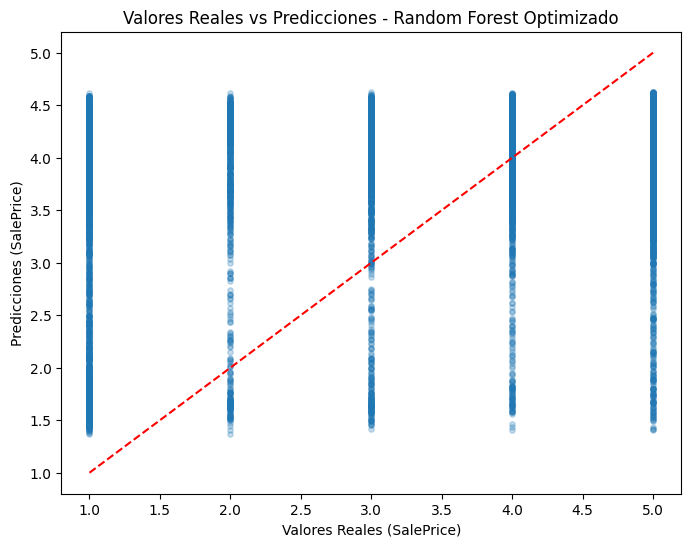

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
}

rf_regressor = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nBest Parameters:", grid_search.best_params_)
print("\nEvaluación del Modelo Random Forest Optimizado:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=15)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (review_score)")
plt.ylabel("Predicciones (review_score)")
plt.title("Valores Reales vs Predicciones - Random Forest Optimizado")
plt.show()

Al observar el rendimiento de este modelo, nos damos cuenta que los valores iniciales utilizados fueron bastante precisos. Al realizar el gridsearch con diferentes valores de profundidad, nos damos cuenta que nuestra hipotesis anterior sobre el modelo necesitando mas detalle era incorrecta. En este caso, el modelo mas efectivo encontrado resulto siendo en max_depth = 10, el valor inferior establecido. Observando nuevamente el modelo, podemos concluir que el 'problema' se encuentra con la distribucion de la variable objetivo. Ya que la mayoria de reviews se encuentra alrededor de 4 o 5 puntos el modelo suele predecirlas de manera mas precisa. Esto tambien lleva a que haga 'overshoot' con las variables inferiores. Donde en la grafica podemos observar un valor predecido de 3-5 para valores reales de 2 por ejemplo.

10 Features mas importantes:
                    Feature  Importance
2            delivery_delta    0.602647
6                item_count    0.076628
1             delivery_days    0.066091
13     shipping_distance_km    0.038525
7       order_freight_value    0.029192
12         freight_to_price    0.025000
0   estimated_delivery_days    0.023496
10   avg_product_volume_cm3    0.017138
11   total_order_volume_cm3    0.016768
4         avg_product_price    0.015765


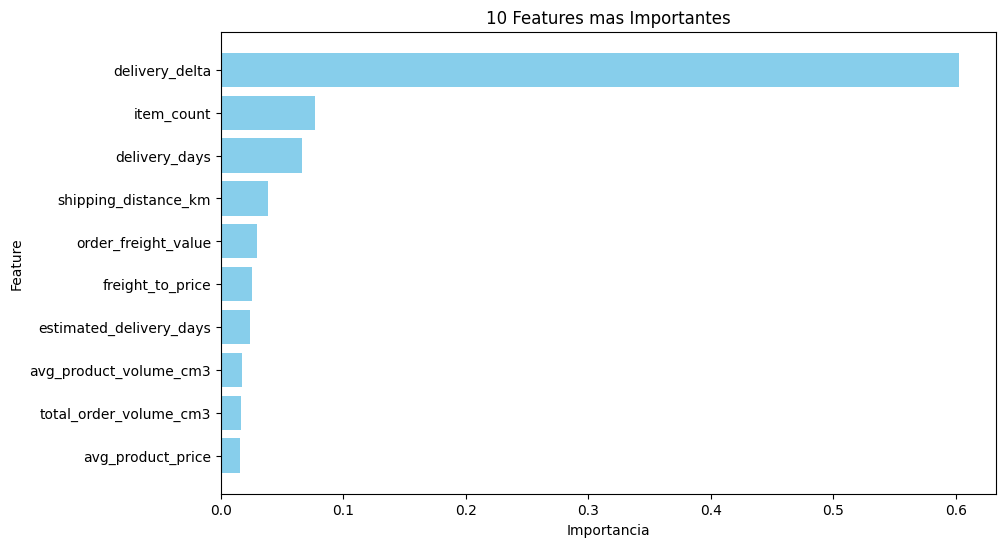

In [ ]:
feature_importances = best_rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("10 Features mas importantes:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('10 Features mas Importantes')
plt.gca().invert_yaxis()
plt.show()

En cuanto a los features mas importantes, el modelo nos indica que entre los factores mas importantes relacionados a la experiencia del cliente se encuentra del 'delivery_delta'. Esta variable nos indica que tantos dias luego (o antes) de la fecha de entrega estimada fue entregado el pedido.

### Delivery Days

Importamos el regresor de random forest, creamos los splits X e Y tanto para prueba como para entrenamiento y entrenamos nuestro modelo inicial.

Evaluación del Modelo Random Forest:
Mean Squared Error (MSE): 58.726834
Mean Absolute Error (MAE): 4.960618
R-squared (R²): 0.342448


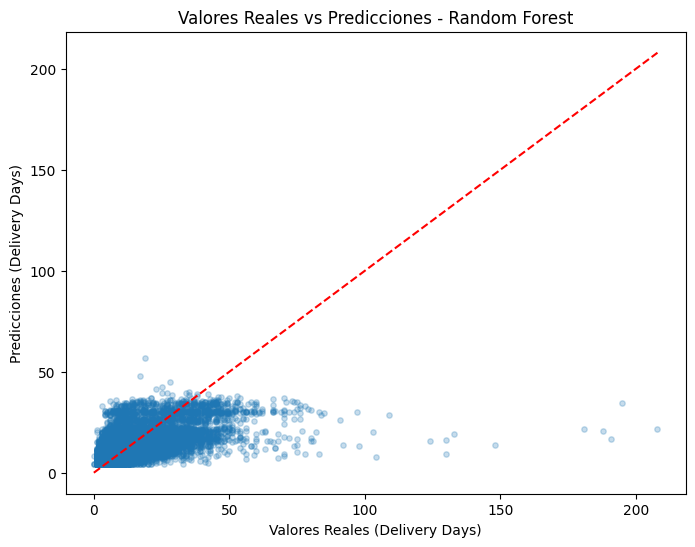

In [ ]:
# Separacion X / Y train
x_train = dftrain_d.drop(columns=['delivery_days'])
y_train = dftrain_d['delivery_days']

# Separacion X / Y test
x_test = dftest_d.drop(columns=['delivery_days'])
y_test = dftest_d['delivery_days']

# Creacion de modelo
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 42, max_depth = 4)

# Entrenamiento del modelo
rf_regressor.fit(x_train, y_train)

# Predicciones con el modelo
y_pred = rf_regressor.predict(x_test)

# Estadisticas de rendimiento
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluación del Modelo Random Forest:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

#Plot de resultados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=15)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Valores Reales (Delivery Days)")
plt.ylabel("Predicciones (Delivery Days)")
plt.title("Valores Reales vs Predicciones - Random Forest")
plt.show()

Este modelo parece tener un rendimiento bastante pobre, segun la grafica el modelo falla en predecir correctamente valores mas altos. Esto se debe en parte a que son valores atipicos, como lo puede ser un delivery de 200+ dias. Sin embargo, observamos que no logra captar correctamente en trend desde un principio y parece mas que todo seguir una linea horizontal. Posiblemente con un parametro de profundidad mas alto se obtengan mejores resultados.


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Evaluación del Modelo Random Forest Optimizado:
Mean Squared Error (MSE): 58.425176
Mean Absolute Error (MAE): 4.919904
R-squared (R²): 0.345825


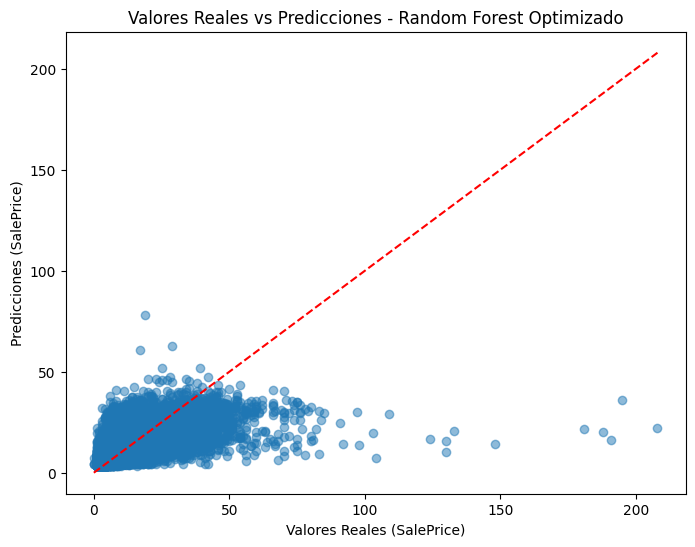

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

rf_regressor = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nBest Parameters:", grid_search.best_params_)
print("\nEvaluación del Modelo Random Forest Optimizado:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (SalePrice)")
plt.ylabel("Predicciones (SalePrice)")
plt.title("Valores Reales vs Predicciones - Random Forest Optimizado")
plt.show()

Por ultimo, podemos investigar los features mas importantes dentro de este modelo.

10 Features mas importantes:
                   Feature  Importance
10         different_state    0.277883
13            review_score    0.225264
9     shipping_distance_km    0.158388
3      order_freight_value    0.059246
2               item_count    0.031966
8         freight_to_price    0.026122
6   avg_product_volume_cm3    0.025507
7   total_order_volume_cm3    0.022354
0        avg_product_price    0.019631
54       customer_state_RJ    0.017996


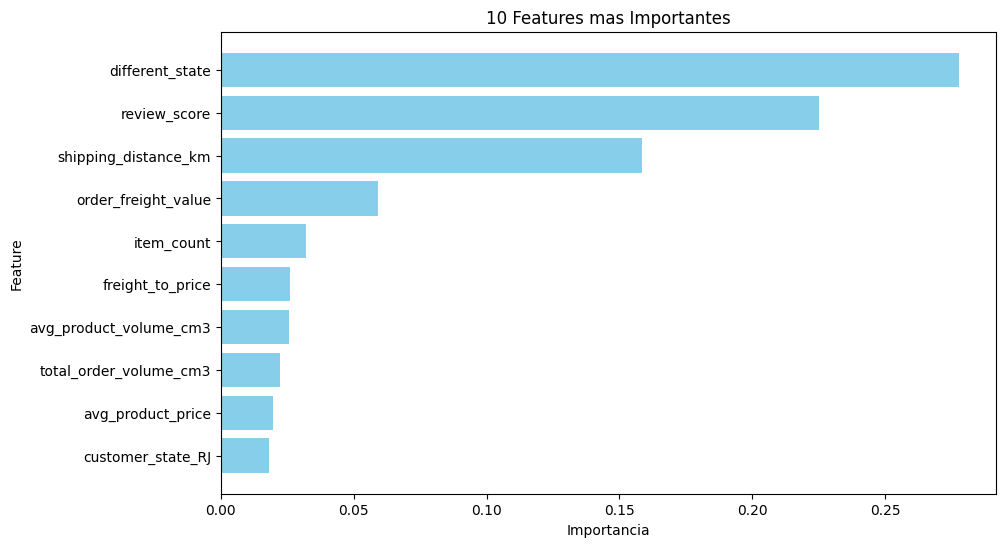

In [ ]:
feature_importances = best_rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("10 Features mas importantes:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('10 Features mas Importantes')
plt.gca().invert_yaxis()
plt.show()

## KNN

### Satisfaccion del Cliente

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


x_train = dftrain.drop(columns=['review_score'])
x_train = scaler.fit_transform(x_train)

y_train = dftrain['review_score']

x_test = dftest.drop(columns=['review_score'])
x_test = scaler.fit_transform(x_test)
y_test = dftest['review_score']

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Crear el modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5) 
knn_model.fit(x_train, y_train)

# Predicciones
y_pred_knn = knn_model.predict(x_test)

# Evaluación
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f"Resultados KNN Regression:")
print(f"MAE  = {mae_knn:.2f} días")
print(f"RMSE = {rmse_knn:.2f} días")
print(f"R²   = {r2_knn:.4f}")

Resultados KNN Regression:
MAE  = 0.92 días
RMSE = 1.26 días
R²   = 0.0412


In [ ]:
param_grid = {
    'n_neighbors': [9, 11, 13, 15, 17],
    'p': [1,2]
}

 # Create the KNN Regressor
knn = KNeighborsRegressor()
 

 # Create the GridSearchCV object
grid_search = GridSearchCV(
  knn, param_grid, cv=5, scoring='neg_mean_absolute_error'
 )  # cv=5 means 5-fold cross-validation
 

 # Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)
 

 # Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
 

 # Get the best model
best_knn = grid_search.best_estimator_
 

 # Make predictions on the test set using the best model
y_pred_knn = best_knn.predict(x_test)
 

 # Evaluate the best model
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)
 

print(f"Resultados KNN Regression (Best Model):")
print(f"MAE  = {mae_knn:.2f} días")
print(f"RMSE = {rmse_knn:.2f} días")
print(f"R²   = {r2_knn:.4f}")

Best parameters: {'n_neighbors': 17, 'p': 1}
Resultados KNN Regression (Best Model):
MAE  = 0.90 días
RMSE = 1.19 días
R²   = 0.1460


### Delivery Days

In [ ]:
x_train = dftrain_d.drop(columns=['delivery_days'])
y_train = dftrain_d['delivery_days']

x_test = dftest_d.drop(columns=['delivery_days'])
y_test = dftest_d['delivery_days']

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Crear el modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5) 
knn_model.fit(x_train, y_train)

# Predicciones
y_pred_knn = knn_model.predict(x_test)

# Evaluación
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f"Resultados KNN Regression:")
print(f"MAE  = {mae_knn:.2f} días")
print(f"RMSE = {rmse_knn:.2f} días")
print(f"R²   = {r2_knn:.4f}")

Resultados KNN Regression:
MAE  = 5.80 días
RMSE = 9.05 días
R²   = 0.0824


In [ ]:


param_grid = {
    'n_neighbors': [9, 11, 13, 15, 17],
    'p': [1,2]
}

 # Create the KNN Regressor
knn = KNeighborsRegressor()
 

 # Create the GridSearchCV object
grid_search = GridSearchCV(
  knn, param_grid, cv=5, scoring='neg_mean_absolute_error'
 )  # cv=5 means 5-fold cross-validation
 

 # Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)
 

 # Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
 

 # Get the best model
best_knn = grid_search.best_estimator_
 

 # Make predictions on the test set using the best model
y_pred_knn = best_knn.predict(x_test)
 

 # Evaluate the best model
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)
 

print(f"Resultados KNN Regression (Best Model):")
print(f"MAE  = {mae_knn:.2f} días")
print(f"RMSE = {rmse_knn:.2f} días")
print(f"R²   = {r2_knn:.4f}")

Best parameters: {'n_neighbors': 17, 'p': 1}
Resultados KNN Regression (Best Model):
MAE  = 5.53 días
RMSE = 8.64 días
R²   = 0.1643


## SVR

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt




X_train_rs = dftrain.drop(columns=['review_score']) 
y_train_rs = dftrain['review_score']               

X_test_rs  = dftest.drop(columns=['review_score'])
y_test_rs  = dftest['review_score']

# ------- pipeline + búsqueda ----------
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

param_grid_rs = {
    'svr__kernel': ['rbf'],
    'svr__C'      : [0.1, 1, 10],
    'svr__epsilon': [0.05, 0.2],
    'svr__gamma'  : ['scale', 0.01] 
}

gs_rs = HalvingGridSearchCV(
    svr_pipe,
    param_grid_rs,  
    factor=3,        
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)


Exception ignored in: <function ResourceTracker.__del__ at 0x79084ce6d080>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x754da5975080>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x74a531e7d080>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/reso

KeyboardInterrupt: 

In [ ]:
from joblib import parallel_backend

with parallel_backend('threading'):
    gs_rs.fit(X_train_rs, y_train_rs)
    
best_svr_rs = gs_rs.best_estimator_
print("Mejores hiper-parámetros (review_score):", gs_rs.best_params_)

# ------- evaluación ----------
y_pred_rs = best_svr_rs.predict(X_test_rs)
print(f"MAE  = {mean_absolute_error(y_test_rs, y_pred_rs):.3f}")
print(f"RMSE = {mean_squared_error(y_test_rs, y_pred_rs, squared=False):.3f}")
print(f"R²   = {r2_score(y_test_rs, y_pred_rs):.4f}")

plt.figure(figsize=(7,5))
plt.scatter(y_test_rs, y_pred_rs, alpha=0.3, s=15)
plt.plot([y_test_rs.min(), y_test_rs.max()],
         [y_test_rs.min(), y_test_rs.max()],
         'r--')
plt.xlabel("Review real"); plt.ylabel("Predicción")
plt.title("SVR – review_score"); plt.grid(True)
plt.show()


In [ ]:
# ------- splits ya creados ----------
X_train_dd = dftrain_d.drop(columns=['delivery_days'])
y_train_dd = dftrain_d['delivery_days']

X_test_dd  = dftest_d.drop(columns=['delivery_days'])
y_test_dd  = dftest_d['delivery_days']

# ------- pipeline + búsqueda ----------
svr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

param_grid_dd = {
    'svr__kernel': ['rbf'],
    'svr__C'      : [0.1, 1, 10],
    'svr__epsilon': [0.05, 0.2],
    'svr__gamma'  : ['scale', 0.01] 
}

gs_dd = HalvingGridSearchCV(
    svr_pipe,
    param_grid_dd,  
    factor=3,        
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)



In [ ]:
from joblib import parallel_backend

with parallel_backend('threading'):
    gs_dd.fit(X_train_dd, y_train_dd)

best_svr_dd = gs_dd.best_estimator_
print("Mejores hiper-parámetros (delivery_days):", gs_dd.best_params_)

# ------- evaluación ----------
y_pred_dd = best_svr_dd.predict(X_test_dd)
print(f"MAE  = {mean_absolute_error(y_test_dd, y_pred_dd):.2f} días")
print(f"RMSE = {mean_squared_error(y_test_dd, y_pred_dd, squared=False):.2f} días")
print(f"R²   = {r2_score(y_test_dd, y_pred_dd):.4f}")

plt.figure(figsize=(7,5))
plt.scatter(y_test_dd, y_pred_dd, alpha=0.3, s=15)
plt.plot([y_test_dd.min(), y_test_dd.max()],
         [y_test_dd.min(), y_test_dd.max()],
         'r--')
plt.xlabel("Delivery real (días)"); plt.ylabel("Predicción (días)")
plt.title("SVR – delivery_days"); plt.grid(True)
plt.show()